## Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os

## Model


In [2]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        img = self.model(z)

        return img

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(-1, 1)


In [4]:
class Corruptor:
    def __init__(self, corruption_types=None):
        if corruption_types is None:
            corruption_types = ['mask']
        self.corruption_types = corruption_types

    def apply_mask(self, img):
        mask = torch.rand_like(img) > 0.5
        return img * mask

    def add_gaussian_noise(self, img):
        noise = torch.randn_like(img) * 0.2
        return img + noise

    def add_speckle_noise(self, img):
        noise = torch.randn_like(img) * 0.2
        return img + img * noise

    def add_thermal_noise(self, img):
        noise = torch.randn_like(img) * 0.1
        return img + noise

    def add_poisson_noise(self, img):
        img = torch.clamp(img, min=0, max=1)
        noise = torch.poisson(img)
        return img + noise

    def add_quantization_noise(self, img):
        return torch.round(img * 255) / 255

    def add_motion_artifacts(self, img):
        shift = torch.randint(-5, 5, (2,))
        return torch.roll(img, shifts=tuple(shift), dims=(1, 2))

    def add_reverberation_artifacts(self, img):
        echo = torch.nn.functional.pad(img, (5, 5, 5, 5), mode='reflect')
        return img + 0.5 * echo[:, :, 5:-5, 5:-5]

    def add_electronic_interference(self, img):
        interference = torch.sin(torch.linspace(0, 20, img.size(2)))
        interference = interference.view(1, 1, 1, -1).expand_as(img)
        return img + interference * 0.1

    def corrupt(self, img):
        corrupted_img = img.clone()
        for corruption_type in self.corruption_types:
            if corruption_type == 'mask':
                corrupted_img = self.apply_mask(corrupted_img)
            elif corruption_type == 'gaussian_noise':
                corrupted_img = self.add_gaussian_noise(corrupted_img)
            elif corruption_type == 'speckle_noise':
                corrupted_img = self.add_speckle_noise(corrupted_img)
            elif corruption_type == 'thermal_noise':
                corrupted_img = self.add_thermal_noise(corrupted_img)
            elif corruption_type == 'poisson_noise':
                corrupted_img = self.add_poisson_noise(corrupted_img)
            elif corruption_type == 'quantization_noise':
                corrupted_img = self.add_quantization_noise(corrupted_img)
            elif corruption_type == 'motion_artifacts':
                corrupted_img = self.add_motion_artifacts(corrupted_img)
            elif corruption_type == 'reverberation_artifacts':
                corrupted_img = self.add_reverberation_artifacts(corrupted_img)
            elif corruption_type == 'electronic_interference':
                corrupted_img = self.add_electronic_interference(corrupted_img)
            else:
                raise ValueError(f"Unknown corruption type: {corruption_type}")
        return corrupted_img

In [5]:
class AmbientGAN:
    def __init__(self, generator, discriminator, corruptor, noise_dim, lr=0.0002, b1=0.5, b2=0.999):
        self.generator = generator
        self.discriminator = discriminator
        self.corruptor = corruptor
        self.noise_dim = noise_dim

        self.adversarial_loss = nn.BCELoss()
        self.optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
        self.optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    def save_generated_images(self, epoch, img_dim, device, output_dir="output"):
        z = torch.randn(img_dim, self.noise_dim, device=device)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with torch.no_grad():
            fake_images = self.generator(z).detach().cpu()
        vutils.save_image(fake_images, f"{output_dir}/fake_images_epoch_{epoch}.png", normalize=True)

    def train(self, data_loader, epochs, device):
        for epoch in range(epochs):
            for i, (imgs, _) in enumerate(data_loader):

                valid = torch.ones(imgs.size(0), 1, device=device)
                fake = torch.zeros(imgs.size(0), 1, device=device)

                real_imgs = imgs.to(device)
                # print(real_imgs.shape, "!!!!!!!!!")
                corrupted_real_imgs = self.corruptor.corrupt(real_imgs)
                # print(corrupted_real_imgs.shape, "corrupt!!!!!!!!!")

                self.optimizer_G.zero_grad()

                z = torch.randn(imgs.size(0), self.noise_dim, device=device)
                generated_imgs = self.generator(z)
                # print(generated_imgs.shape, "generated!!!!!!!!!")
                corrupted_generated_imgs = self.corruptor.corrupt(generated_imgs)
                # print(corrupted_generated_imgs.shape, "corrupt!!!!!!!!!")

                g_loss = self.adversarial_loss(self.discriminator(corrupted_generated_imgs), valid)
                g_loss.backward()
                self.optimizer_G.step()

                self.optimizer_D.zero_grad()
                # print('REAL LOSS')
                real_loss = self.adversarial_loss(self.discriminator(corrupted_real_imgs), valid)
                # print('FAKE LOSS')
                fake_loss = self.adversarial_loss(self.discriminator(corrupted_generated_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                self.optimizer_D.step()

                if i % 100 == 0:
                    print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(data_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

            # Save generated images at the end of each epoch
            self.save_generated_images(epoch, imgs.size(0), device)

## Training on MNIST

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Hyperparameters
noise_dim = 100
batch_size = 64
epochs = 50
lr = 0.0002
num_frames = 1
crop_dim = (28, 28)

# Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist = MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [7]:
noise_types = ['mask', \
               'gaussian_noise', \
               'speckle_noise', \
               'thermal_noise', \
               'poisson_noise', \
              #  'quantization_noise', \
               'motion_artifacts', \
              #  'reverberation_artifacts'\
               ]
# Initialize models
generator = Generator(noise_dim)
discriminator = Discriminator()
corruptor = Corruptor(corruption_types=noise_types)
gan = AmbientGAN(generator, discriminator, corruptor, noise_dim)

Displaying Corrupted Images

In [8]:
# Get a batch of data
data_iter = iter(data_loader)
imgs, _ = next(data_iter)

# Corrupt the data
# all_noise_types = ['mask', 'gaussian_noise', 'speckle_noise', 'thermal_noise', \
#                'poisson_noise', 'quantization_noise', 'motion_artifacts', \
#                'reverberation_artifacts', 'electronic_interference']

vis_corruptor = Corruptor(corruption_types=noise_types)
corrupted_imgs = vis_corruptor.corrupt(imgs)

# Visualize the corrupted data
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(corrupted_imgs[i].numpy().reshape(28, 28), cmap='hot')
    plt.axis('off')
plt.show()


In [9]:

# Train the GAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

gan.train(data_loader, epochs, device)


## Training on Mouse fUSi Data

In [10]:
class fUSi_Generator(nn.Module):
    def __init__(self, noise_dim, num_frames):
        super(fUSi_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, 1, 0, bias=False), # (N, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),       # (N, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),       # (N, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),        # (N, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),         # (N, 32, 64, 64)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, num_frames, 4, 2, 1, bias=False),          # (N, 1, 128, 128)
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        img = self.model(z)
        return img


class fUSi_Discriminator(nn.Module):
    def __init__(self, num_frames):
        super(fUSi_Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(num_frames, 32, 3, 2, 1, bias=False),   # Reduced kernel size to 3
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),  # (N, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # (N, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),# (N, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),# (N, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  # (N, 1, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        # layer_num = 0
        # print(f"Layer {0}: {img.shape}")
        # for layer in self.model:
        #     img = layer(img)
        #     print(f"Layer {layer_num}: {img.shape}")
        #     layer_num += 1
        img = self.model(img)

        validity = img
        return validity.view(-1, 1)
    

class AmbientGAN:
    def __init__(self, generator, discriminator, corruptor, noise_dim, lr=0.0002, b1=0.5, b2=0.999):
        self.generator = generator
        self.discriminator = discriminator
        self.corruptor = corruptor
        self.noise_dim = noise_dim

        self.adversarial_loss = nn.BCELoss()
        self.optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
        self.optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    def save_generated_images(self, epoch, img_dim, device, output_dir="output"):
        z = torch.randn(img_dim, self.noise_dim, device=device)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with torch.no_grad():
            fake_images = self.generator(z).detach().cpu()
        fake_images = fake_images[:,0,:,:].unsqueeze(1)
        print(fake_images.shape)
        vutils.save_image(fake_images, f"{output_dir}/fake_images_epoch_{epoch}.png", normalize=True)

    def train(self, data_loader, epochs, device):
        d_losses = []
        g_losses = []
        for epoch in range(epochs):
            for i, (iq_signal, S_signal, dop_signal, _) in enumerate(data_loader):
                imgs = S_signal.permute((0, 3, 1, 2))
                valid = torch.ones(imgs.size(0), 1, device=device)
                fake = torch.zeros(imgs.size(0), 1, device=device)

                corrupted_real_imgs = imgs.to(device)
                # print(real_imgs.shape, "!!!!!!!!!")

                self.optimizer_G.zero_grad()

                z = torch.randn(imgs.size(0), self.noise_dim, device=device)
                generated_imgs = self.generator(z)
                # print(generated_imgs.shape, "generated!!!!!!!!!")
                corrupted_generated_imgs = generated_imgs # self.corruptor.corrupt(generated_imgs)
                # print(corrupted_generated_imgs.shape, "corrupt!!!!!!!!!")

                g_loss = self.adversarial_loss(self.discriminator(corrupted_generated_imgs), valid)
                g_loss.backward()
                self.optimizer_G.step()

                self.optimizer_D.zero_grad()
                # print('REAL LOSS')
                real_loss = self.adversarial_loss(self.discriminator(corrupted_real_imgs), valid)
                # print('FAKE LOSS')
                fake_loss = self.adversarial_loss(self.discriminator(corrupted_generated_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                self.optimizer_D.step()

                if i % 100 == 0:
                    print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(data_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            # Save generated images at the end of each epoch
            self.save_generated_images(epoch, imgs.size(0), device)
        return d_losses, g_losses

In [11]:
class Corruptor:
    def __init__(self, corruption_types=None):
        if corruption_types is None:
            corruption_types = ['mask']
        self.corruption_types = corruption_types

    def apply_mask(self, img):
        mask = torch.rand_like(img) > 0.5
        return img * mask

    def add_gaussian_noise(self, img):
        noise = torch.randn_like(img) * 0.2
        return img + noise

    def add_speckle_noise(self, img):
        noise = torch.randn_like(img) * 0.2
        return img + img * noise

    def add_thermal_noise(self, img):
        noise = torch.randn_like(img) * 0.1
        return img + noise

    def add_poisson_noise(self, img):
        img = torch.clamp(img, min=0, max=1)
        noise = torch.poisson(img)
        return img + noise

    def add_quantization_noise(self, img):
        return torch.round(img * 255) / 255

    def add_motion_artifacts(self, img):
        shift = torch.randint(-5, 5, (2,))
        return torch.roll(img, shifts=tuple(shift), dims=(1, 2))

    def add_reverberation_artifacts(self, img):
        echo = torch.nn.functional.pad(img, (5, 5, 5, 5), mode='reflect')
        return img + 0.5 * echo[:, :, 5:-5, 5:-5]

    def add_electronic_interference(self, img):
        interference = torch.sin(torch.linspace(0, 20, img.size(2)))
        interference = interference.view(1, 1, 1, -1).expand_as(img)
        return img + interference * 0.1

    def corrupt(self, img):
        corrupted_img = img.clone()
        for corruption_type in self.corruption_types:
            if corruption_type == 'mask':
                corrupted_img = self.apply_mask(corrupted_img)
            elif corruption_type == 'gaussian_noise':
                corrupted_img = self.add_gaussian_noise(corrupted_img)
            elif corruption_type == 'speckle_noise':
                corrupted_img = self.add_speckle_noise(corrupted_img)
            elif corruption_type == 'thermal_noise':
                corrupted_img = self.add_thermal_noise(corrupted_img)
            elif corruption_type == 'poisson_noise':
                corrupted_img = self.add_poisson_noise(corrupted_img)
            elif corruption_type == 'quantization_noise':
                corrupted_img = self.add_quantization_noise(corrupted_img)
            elif corruption_type == 'motion_artifacts':
                corrupted_img = self.add_motion_artifacts(corrupted_img)
            elif corruption_type == 'reverberation_artifacts':
                corrupted_img = self.add_reverberation_artifacts(corrupted_img)
            elif corruption_type == 'electronic_interference':
                corrupted_img = self.add_electronic_interference(corrupted_img)
            elif corruption_type == 'rr_crop':
                
            else:
                raise ValueError(f"Unknown corruption type: {corruption_type}")
        return corrupted_img

In [12]:
import utilsS
import datasetloader

# Hyperparameters
noise_dim = 100
epochs = 150
lr = 0.0002
num_frames = 1

crop_dim = [128, 128]
batch_size = 64
data_path_train = "/home/aditijc/data_onemouse/MousefUSi-data/data_300/data300_oneAnimalOut_Mouse2ABR/train"
num_frames = 32
iq_signal_mode = 'real'
standardization_constant_path = "/home/aditijc/data_onemouse/MousefUSi-data/data_300/data300_oneAnimalOut_Mouse2ABR/train_real_32_128_withtransformation_scalar_standardization_constant.pt"
standardization_constant = torch.load(standardization_constant_path)
# only to scale all by one scalar value
standardization_constant["iq_mean"] = torch.mean(
    standardization_constant["iq_mean"]
)

standardization_constant["iq_std"] = torch.mean(
    standardization_constant["iq_std"]
)
standardization_constant["dop_mean"] = torch.mean(
    standardization_constant["dop_mean"]
)
standardization_constant["dop_std"] = torch.mean(
    standardization_constant["dop_std"]
)

transform_train = [
    utilsS.FUSCenterCrop(
        crop_dim,
        # scale=[0.08, 1.0],
        # ratio=[0.9, 1.1],
        # antialias=True,
    )
    ]

train_dataset = datasetloader.FUSdataset_S_L(
        data_path_train,
        num_frames=num_frames,
        iq_signal_mode=iq_signal_mode,
        standardization_constant=standardization_constant,
        transform=transform_train,
    )

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=batch_size,
    )




In [13]:
noise_types = ['mask', \
               'gaussian_noise', \
               'speckle_noise', \
               'thermal_noise', \
               'poisson_noise', \
              #  'quantization_noise', \
               'motion_artifacts', \
              #  'reverberation_artifacts'\
               ]
# Initialize models
generator = fUSi_Generator(noise_dim, num_frames)
discriminator = fUSi_Discriminator(num_frames)
corruptor = Corruptor(corruption_types=noise_types)
gan = AmbientGAN(generator, discriminator, corruptor, noise_dim)

torch.Size([64, 128, 128, 32])


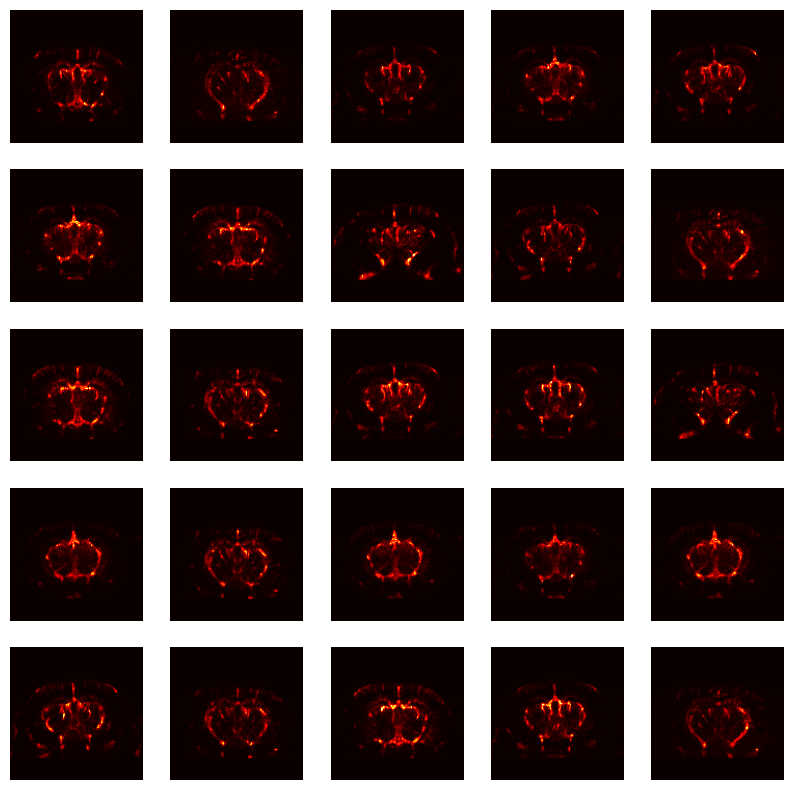

In [14]:
# Get a batch of data

data_iter = iter(train_loader)
iq, s, dop, _ = next(data_iter)
imgs = s
print(imgs.shape)


# Visualize the corrupted data
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.mean(imgs[i].numpy(), axis=2).reshape(128, 128), cmap='hot')
    plt.axis('off')
plt.show()


In [15]:
# Train the GAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

d_losses, g_losses = gan.train(train_loader, epochs, device)


[Epoch 0/150] [Batch 0/11] [D loss: 0.7376710176467896] [G loss: 0.7027249336242676]
torch.Size([33, 1, 128, 128])
[Epoch 1/150] [Batch 0/11] [D loss: 0.03755570948123932] [G loss: 3.4345803260803223]
torch.Size([33, 1, 128, 128])
[Epoch 2/150] [Batch 0/11] [D loss: 0.020045947283506393] [G loss: 3.7520973682403564]
torch.Size([33, 1, 128, 128])
[Epoch 3/150] [Batch 0/11] [D loss: 0.010559340007603168] [G loss: 5.186624526977539]
torch.Size([33, 1, 128, 128])
[Epoch 4/150] [Batch 0/11] [D loss: 0.01344586443156004] [G loss: 4.290729522705078]
torch.Size([33, 1, 128, 128])
[Epoch 5/150] [Batch 0/11] [D loss: 0.02118290774524212] [G loss: 4.0669450759887695]
torch.Size([33, 1, 128, 128])
[Epoch 6/150] [Batch 0/11] [D loss: 0.5724791288375854] [G loss: 0.5329926609992981]
torch.Size([33, 1, 128, 128])
[Epoch 7/150] [Batch 0/11] [D loss: 0.028458096086978912] [G loss: 12.202765464782715]
torch.Size([33, 1, 128, 128])
[Epoch 8/150] [Batch 0/11] [D loss: 0.06940880417823792] [G loss: 3.89689